# README

To whomever it may concern, here is our work, I hope you like it.



# Helper Code 
(don't read, just run)

In [1]:
# External Packages
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as t

import itertools
from matplotlib.colors import TwoSlopeNorm
import random
import importlib


from importlib import reload
from tqdm import tqdm
import gc

In [2]:
# Custom Packages
import model
import data as scd
from utils import model_scan as ms
from utils import model_analytics as ma
from utils import synthetic_model as sm
from utils import hadamard_model as hm
from utils import opt_linear
from utils import opt_nonlin_sym
from utils.plot import lrp 

## Load trained models

### Sample ratio sweep

In [3]:
# Parameters
n_sparse = 500
n_dense = 500
num_ratios = 20
ratios = np.linspace(0.002001, 1, num_ratios)
p_feats = [0.01]

# Linear model theory
opt_lin_models =  opt_linear.multiple_models_losses(n_sparse, ratios, p_feats)

# Trained linear model
experiment_name = "linear_model_example"
try:
    trn_lin_models = ms.load_trained_models(experiment_name)
except:
    trn_lin_models = ms.train_multiple_models(n_sparse, ratios, p_feats, non_linearities = None, experiment_name=experiment_name)
    
# Trained non-linear models
experiment_name = "nonlinear_model_example"
try:
    trn_nonlin_models = ms.load_trained_models(experiment_name)
except:
    trn_nonlin_models = ms.train_multiple_models(n_sparse, ratios, p_feats, non_linearities=True, experiment_name=experiment_name)


### ratio & p_feat sweep

In [4]:
# 
LRP_n_sparses = [100, 500, 1000, 2000, 3000]
grid_width=10
min_RP = 0.002001
max_RP = 0.8

class RP_sweep_params:
    def __init__(self) -> None:
        
        self.ratio_res = 10
        self.min_ratio = 0.002001
        self.max_ratio = 0.8
        self.ratios = np.linspace(self.min_ratio, self.max_ratio, self.ratio_res)
        
        self.p_feat_res = self.ratio_res
        self.min_p_feat = self.min_ratio
        self.max_p_feat = self.max_ratio
        self.p_feats = np.linspace(self.min_p_feat, self.max_p_feat, self.p_feat_res)

sweep_params = RP_sweep_params()

In [5]:
# trained models
def LRP_nonlin_trained_models(n_sparse, sweep_params = RP_sweep_params()):
    experiment_name = lambda n_sparse: f"LRP_{n_sparse}"
    try:
        return ms.models_to_dataframe(ms.load_trained_models(experiment_name(n_sparse)))
    except:
        return ms.models_to_dataframe(ms.train_multiple_models(n_sparse, sweep_params.ratios, sweep_params.p_feats, activations = ["identity"], experiment_name=experiment_name(n_sparse)))
    
def LRP_lin_trained_models(n_sparse, sweep_params = RP_sweep_params()):
    experiment_name = lambda n_sparse: f"LRP_lin_{n_sparse}"
    try:
        return ms.models_to_dataframe(ms.load_trained_models(experiment_name(n_sparse)))
    except:
        return ms.models_to_dataframe(ms.train_multiple_models(n_sparse, sweep_params.ratios, sweep_params.p_feats, activations = ["relu"], experiment_name=experiment_name(n_sparse)))

In [6]:
# synthetic models
def LRP_synthetic_models(n_sparse, sweep_params = RP_sweep_params()):
    return ms.models_to_dataframe(ms.train_multiple_synthetic_models(n_sparse, sweep_params.ratios, sweep_params.p_feats))

def LRP_hadamard_models(n_sparse, sweep_params = RP_sweep_params()):
    return ms.models_to_dataframe(ms.train_multiple_hadamard_models(n_sparse, sweep_params.ratios, sweep_params.p_feats, num_samples=40))


## Plotting Model Behaviors

### Loss vs ratio

In [11]:
def plot_synthetic():
    plt.plot(ratios, [sm.optimal_params(int(ratio * n_sparse), n_sparse, feature_probability)[2] for ratio in tqdm(ratios)],
             marker='v', linestyle='none', label='Analytic Synthetic')

def numerical_estimate_synthetic_model(d, D, p):
    Win, Wout = gen_optimal_matrices(D, d, p)

    cfg = sparsecomp.Config(    
    # architecture parameters
        n_sparse=D, n_dense=d, n_hidden_layers=0, tie_dec_enc_weights=False,
        init_layer_bias=False, hidden_layers_bias=False, final_layer_bias=False,
        init_layer_act_func="identity", hidden_layers_act_func="relu", final_layer_act_func="relu",
        
        # training parameters
        data_size = 10_000, batch_size = 10*1024, max_epochs = 50, lr = 3e-3, update_times = 300, convergence_tolerance = 0
    )

    model = sparsecomp.SparseCompModel(cfg)
    model = model.to(device)

    dataconfig = sparsecomp.data.Config(p, D, (0, 1), sparsefunc)
    datafactory_ = sparsecomp.data.DataFactory(dataconfig)
        
    model.load_state_dict({'initial_layer.weight': t.Tensor(Win, device=device).float(),
                            'final_layer.weight': t.Tensor(Wout, device=device).float()})

    data = datafactory_.generate_data_loader(
            data_size=cfg.data_size, 
            batch_size=cfg.batch_size,
            device=device
        )
    
    iterator = iter(data)
    batch, labels = next(iterator)
    batch = batch.to(device)
    labels = labels.to(device)
    predictions, _ = model(batch)
    
    # compute loss, on_loss, and loss_change
    
    loss = t.nn.functional.mse_loss(predictions, labels).item()
    return loss

def plot_synthetic_numerical_loss():
    snumerical_losses = []

    for ratio in tqdm(ratios):
        snumerical_losses.append(numerical_estimate_synthetic_model(int(ratio * n_sparse), n_sparse, feature_probability))
    
    plt.plot(ratios, snumerical_losses, marker='d', linestyle='none', label='Numerical Synthetic')
        
        

### W Matrix
$W = W_{out}\cdot W_{in}$

In [12]:
def plot_Ws_new(model_array):
    
    assert type(model_array) == list
    assert type(model_array[0]) == list
    
    num_rows = len(model_array)
    num_cols = len(model_array[0])
    
    vmin = min([model.W_matrix().min() for row in model_array for model in row])
    vmax = max([model.W_matrix().max() for row in model_array for model in row])
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))
    axes = np.atleast_2d(axes)
    im = None
    for i in range(num_rows):
        for j in range(num_cols):
            cmap = plt.cm.bwr  # Blue-White-Red colormap
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

            model = model_array[i][j]

            im = axes[i,j].imshow(model.W_matrix()[:30,:30], cmap=cmap, norm=norm)
            axes[i,j].set_title(f'W at ratio {model.ratio():.3f}')

    fig.subplots_adjust(right=0.85)  # Make space for the colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.colorbar
    plt.show()

test_ens = [[trn_nonlin_models[i]] for i in {0,1}]
plot_Ws_new(test_ens)

NameError: name 'trn_nonlin_models' is not defined

In [25]:
if len(ratios) > 5:
    plot_model_indices = [1,2,5]
else:
    plot_model_indices = [0,1]
plot_trained_Ws = [nonlinear_models[i].final_layer.weight.data @ nonlinear_models[i].initial_layer.weight.data for i in plot_model_indices]
plot_ratios = [ratios[i] for i in plot_model_indices]
plot_synthetic_Ws = [gen_optimal_matrices(n_sparse, int(n_sparse * ratio), feature_probability) for ratio in plot_ratios]
plot_synthetic_Ws = [Wout @ Win for Win, Wout in plot_synthetic_Ws]    
    

def plot_Ws():
    weights = []
    for i in plot_model_indices:
        model1 = nonlinear_models[i]
        W = model1.final_layer.weight.data @ model1.initial_layer.weight.data
        weights.append(W)

    vmin = min([W.min() for W in weights])
    vmax = max([W.max() for W in weights])

    for W,i in zip(weights, plot_model_indices):
        cmap = plt.cm.bwr  # Blue-White-Red colormap
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        plt.imshow(W[:30,:30], cmap=cmap, norm=norm)
        plt.colorbar()
        plt.title(f'W at ratio {ratios[i]:.3f}')
        plt.show()
    
    return vmin, vmax

def plot_Ws_and_Synthetic_Ws(trained_Ws, synthetic_Ws, ratios):
    assert len(trained_Ws) == len(synthetic_Ws)
    num_rows = len(trained_Ws)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))

    vmin = min([W.min() for W in trained_Ws])
    vmax = max([W.max() for W in trained_Ws])

    im = None
    for i in range(num_rows):
        cmap = plt.cm.bwr  # Blue-White-Red colormap
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

        axes[i,0].imshow(trained_Ws[i][:30,:30], cmap=cmap, norm=norm)
        axes[i,0].set_title(f'W at ratio {ratios[i]:.3f}')

        im = axes[i,1].imshow(synthetic_Ws[i][:30,:30], cmap=cmap, norm=norm)
        axes[i,1].set_title(f'Synthetic W at ratio {ratios[i]:.3f}')

    fig.subplots_adjust(right=0.85)  # Make space for the colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.colorbar
    plt.show()
    
    return vmin, vmax

NameError: name 'nonlinear_models' is not defined

# Remarkable Phenomena 

## Loss vs ratio drama

- Train autoencoders and show exponential decreasing behavior for multiple values of p

We empirically show the difference in compression capability between the following linear and non-linear autoencoders:

$$
\begin{align*}
f_{\text{linear}}(x) &= W_{\text{out}}W_{\text{in}}x\\
f_{\text{nonlinear}}(x) &= \text{ReLU}(W_{\text{out}}W_{\text{in}}x)
\end{align*}.
$$

For this analysis, we assume that $x\in\mathbb R^{D}$ is sparse so that each component is uniform with probability $p$ and zero otherwise. Formally, $x_i=B_iU_i$ where the $B_i$ are Bernoulli($p$), the $U_i$ are Uniform[0,1], and all $B_i$ and $U_i$ are independent.




It is known that for the linear model (1) that the loss as a function of the hidden dimension $d$ is affine in $d$.
\begin{align*}
L^*_{\text{linear}}(d) = -\frac{p(D-d)}{3D}
\end{align*}

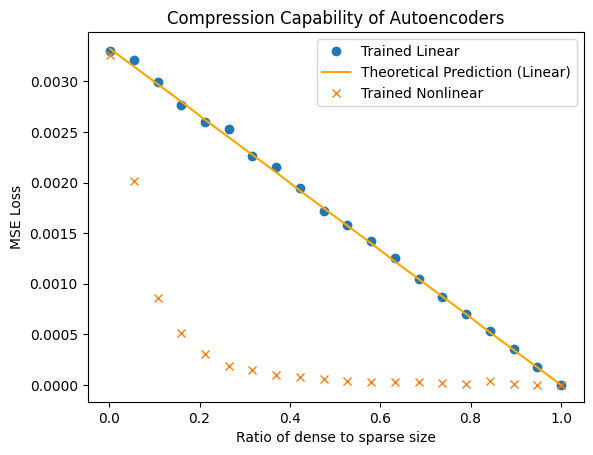

In [23]:
final_losses = lambda models: [model.final_loss() for model in models]
plt.plot(ratios, final_losses(trn_lin_models), 
         marker='o', linestyle='none', label='Trained Linear')
plt.plot(ratios, final_losses(opt_lin_models), 
         color="orange", label='Theoretical Prediction (Linear)')
plt.plot(ratios, final_losses(trn_nonlin_models), 
         marker='x', linestyle='none', label='Trained Nonlinear')

plt.xlabel("Ratio of dense to sparse size")
plt.ylabel("MSE Loss")
plt.title("Compression Capability of Autoencoders")

plt.legend()
plt.show()

We see a dramatic difference in the performance of these two autoencoders. To explain this difference let us look at the weights!

## Scale increase

Let us begin by studying $W=W_{\text{out}}W_{\text{in}}$. 
First let us look at the top $5\times 5$ submatrix of the non-linear model
to get a feel for what we are looking at. 

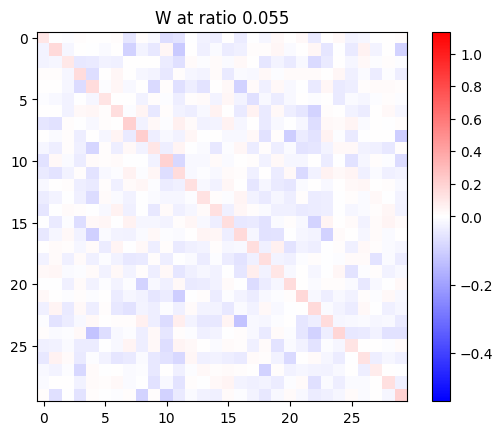

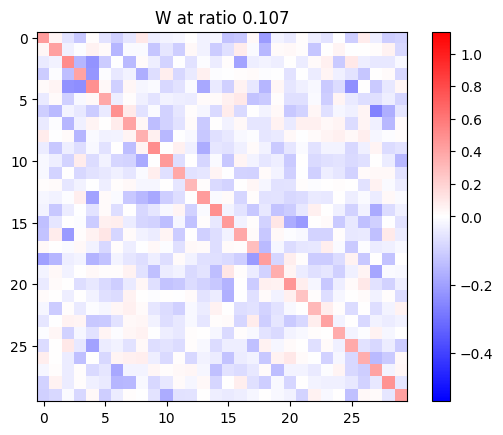

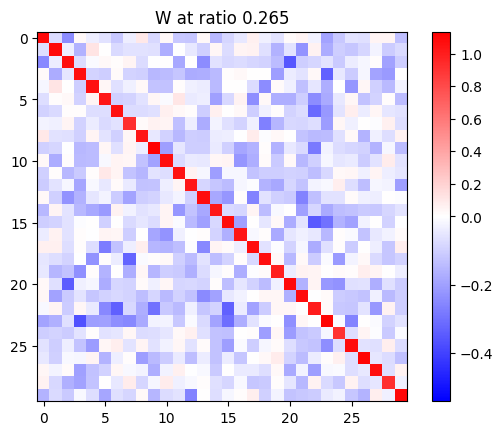

In [32]:
vmin, vmax = plot_Ws()

Let's point out several interesting features in the above plots:

1. There are no zeros on the diagonal, the model encodes all features in superposition, and no feature is privileged.
2. The ratio of negative to positive values in the off-diagonal grows as $d/D$ increases.
3. The diagonals grow as $d/D$ increases and even become greater than 1.


From these features, we can guess what algorithm the model uses. Let's consider the action of this matrix on a typical input vector, $x_{\text{typical}}$. In such a vector, $pD=5$ components are on. Because no feature is privileged, it's sufficient to consider feature 1 in two cases: feature 1 is off, or feature 1 is on. 

__"Off Case"__: Feature 1 is off which happens with high probability $1-p$.

Notice that
$$
(Wx)_1 = W_{11}x_1 + \sum_{i\neq 1 \text{ is on}} W_{1i} x_i = \sum_{i\neq 1 \text{ is on}} W_{1i} x_i := \epsilon_{noise}
$$
and when we apply Relu, we will typically get that $\text{Relu}((Wx)_1) = 0$ because the off-diagonal terms in $W$ are usually negative, while the features $x_i$ are positive. This is good and means that despite the features being in superposition, one feature does not cause another to turn on spuriously, and explains the networks' preference towards negative off-diagonal weights. Postivie weights would cause finite error in this case. However this reliance on negative weights is not free, as we will see in the second case.

__"On Case"__: Feature 1 is on which happens with low probability $p$.

Here we are unable to rely so strongly on the non-linearity to remove the interference from other features, and so
$$
\text{Relu}((Wx)_1) = \text{Relu}\left(W_{11}x_1 + \sum_{i\neq 1 \text{ is on}} W_{1i} x_i \right) \approx W_{11}x_1 + \epsilon_{noise}
$$

because we have assumed that the second noise term is smaller than the first signal term. This noise term, which has negative mean and also finite variance, leads to an unavoidable degredation in the reconstruction. Fortunately since this happens with a low probability we can exchange increased error in this case for decreased error in the previous case.



Now let's address the fact that the diagonals grow, and even grow to be larger than 1. First we note that the scale of the off diagonals initally grow as well. Thus the network appears to be scaling down the overall norm of the $W$ for small $d/D$. This behavior is used to control the error for the "on case". 


In this case, the noise is not filtered by the Relu, and thus it becomes preferable to scale down $W$ to mitigate the effect of the noise. As $d$ increases however, the effect of the noise decreases, and it becomes more advantagous to let more of the feature signal through. Finally, the diagonals become greater than 1, because the noise has a negative mean.



# Alg Revealing Phenomena

## Off diagonal gaussianity

### Trained

In [158]:
# LRP_n_sparses = []
# list_of_all_models = list(itertools.chain(*[ms.load_trained_models(f"LRP_{n_sparse}") for n_sparse in LRP_n_sparses]))
experiment_name = 'non_average_run_09_25'
reload(ms)
list_of_all_models = ms.load_trained_models(experiment_name)
df, model_dict = ms.models_to_dataframe(list_of_all_models)
LRP_n_sparses = df.n_sparse.unique()

In [263]:
label_map = {
    'chi_var': r'$\mathrm{var}_X(\chi)$',
    'chi_varvar': r'$\mathrm{var}_{i}\mathrm{var}_X(\chi)$',
    'log_chi_varvar': r'$\mathrm{log}\mathrm{var}_{i}\mathrm{var}_X(\chi)$',
    'Gaussian_pval': r'$p_{\mathrm{KS}}$',
    'filtered_diag_var': r'\min(\mathrm{var}_i \mathrm{diag}(W),T)'
}

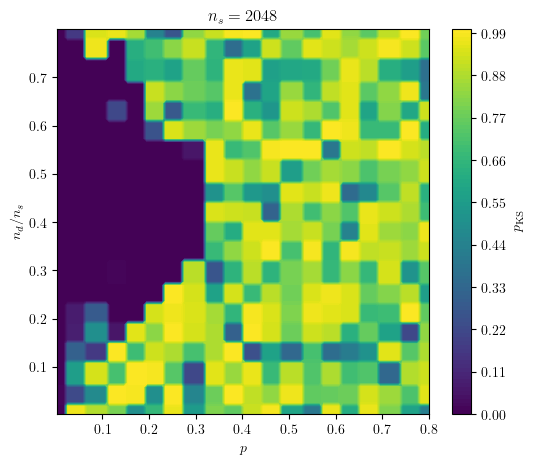

In [248]:
reload(ma)
reload(lrp)
col_name = 'Gaussian_pval'
df[col_name] = df['model_id'].apply(lambda x: ma.get_model_gaussian_ks_stat_and_pval_all(model_dict[x], num_points=100, row=0)[1])

for n_sparse in LRP_n_sparses:
    lrp.plot_column_vs_r_and_p(df[df.n_sparse == n_sparse], col_name, title=f'$n_s= {n_sparse}$', colorbar_label=r'$p_{\mathrm{KS}}$')

In [ ]:
reload(ma)
reload(lrp)
col_name = 'ShapiroWilk'
df[col_name] = df['model_id'].apply(lambda x: ma.get_model_gaussian_ks_stat_and_pval_all(model_dict[x], num_points=100, row=0)[1])

for n_sparse in LRP_n_sparses:
    lrp.plot_column_vs_r_and_p(df[df.n_sparse == n_sparse], col_name, title=f'$n_s= {n_sparse}$', colorbar_label=r'$p_{\mathrm{KS}}$')

## Off Diag Perm Sym

### Varvar RPS
rps = ratio/p_feat sweep

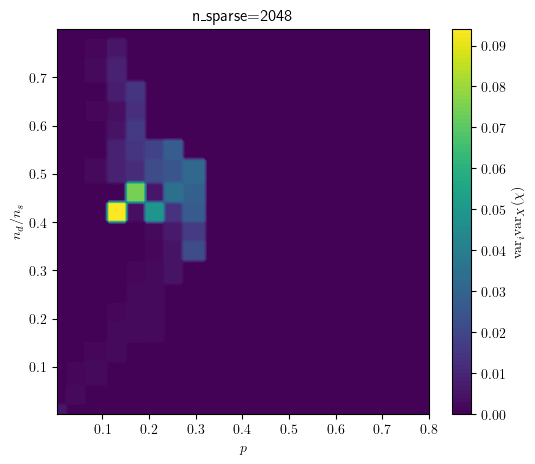

TypeError: 'Index' object is not callable

In [254]:
col_name = 'chi_varvar'
df[col_name] = df['model_id'].apply(lambda x: ma.chi_varvar(model_dict[x], threshold=0.1))

for n_sparse in LRP_n_sparses:
    lrp.plot_column_vs_r_and_p(df[df.n_sparse == n_sparse], col_name, title=f'{n_sparse=}', colorbar_label=label_map[col_name])




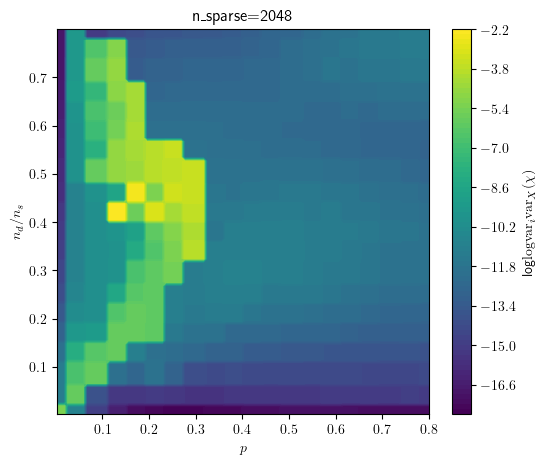

In [260]:
col_name = 'log_chi_varvar'
df[col_name] = df['model_id'].apply(lambda x: np.log(ma.chi_varvar(model_dict[x], threshold=0.1)))

for n_sparse in LRP_n_sparses:
    lrp.plot_column_vs_r_and_p(df[df.n_sparse == n_sparse], col_name, title=f'{n_sparse=}', colorbar_label="log" + label_map[col_name])


### Varvar historgrams
$\sigma\sigma$ = variance of $\chi$ variances

#### Regime where trained known to perform like haramard model

here


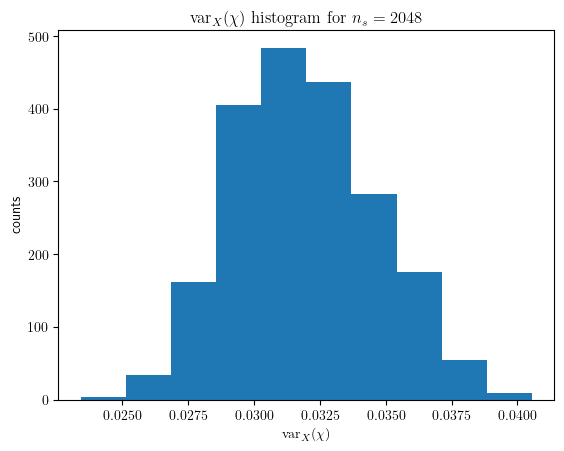

In [232]:
target_ratio = 0.7
target_p_feat = 0.6

col_name = 'chi_var'
df_target = ma.get_closest_models_df(df, p_feat=target_p_feat, ratio=target_ratio).copy()
df_target[col_name] =  df_target['model_id'].apply(lambda x: ma.chi_var(model_dict[x]))

for n_sparse in LRP_n_sparses:   
    plt.hist(df_target[df_target['n_sparse']==n_sparse].chi_var)
    plt.title(label_map[col_name]+r'$\ \mathrm{histogram}\  \mathrm{for}\ $' +f'$n_s = {n_sparse}$')
    plt.xlabel(label_map[col_name])
    plt.ylabel('counts')    
    plt.show()


#### Regime where hadamard fails

here
hello


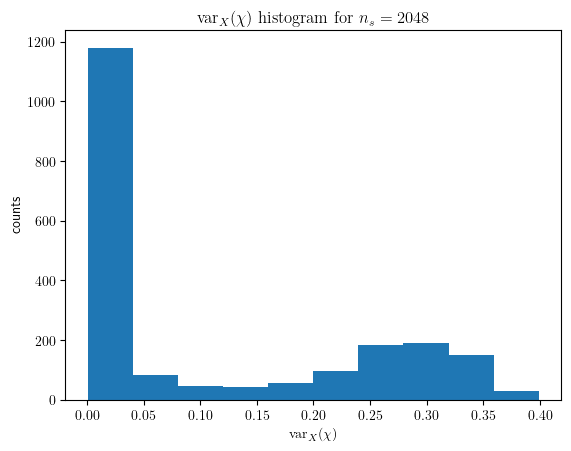

In [234]:
target_ratio = 0.4
target_p_feat = 0.3

df_target = ma.get_closest_models_df(df, p_feat=target_p_feat, ratio=target_ratio).copy()
df_target['chi_var'] =  df_target['model_id'].apply(lambda x: ma.chi_var(model_dict[x]))

for n_sparse in LRP_n_sparses:   
    plt.hist(df_target[df_target['n_sparse']==n_sparse].chi_var)
    plt.title(label_map[col_name]+r'$\ \mathrm{histogram}\  \mathrm{for}\ $' +f'$n_s = {n_sparse}$')
    plt.xlabel(label_map[col_name])
    plt.ylabel('counts')    
    plt.show()

### Varvar line cuts

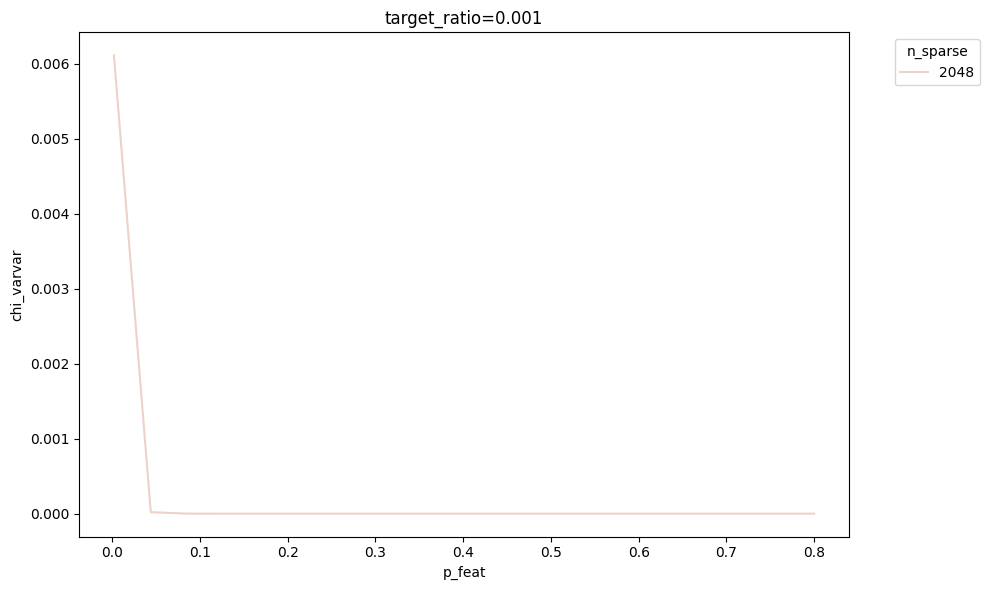

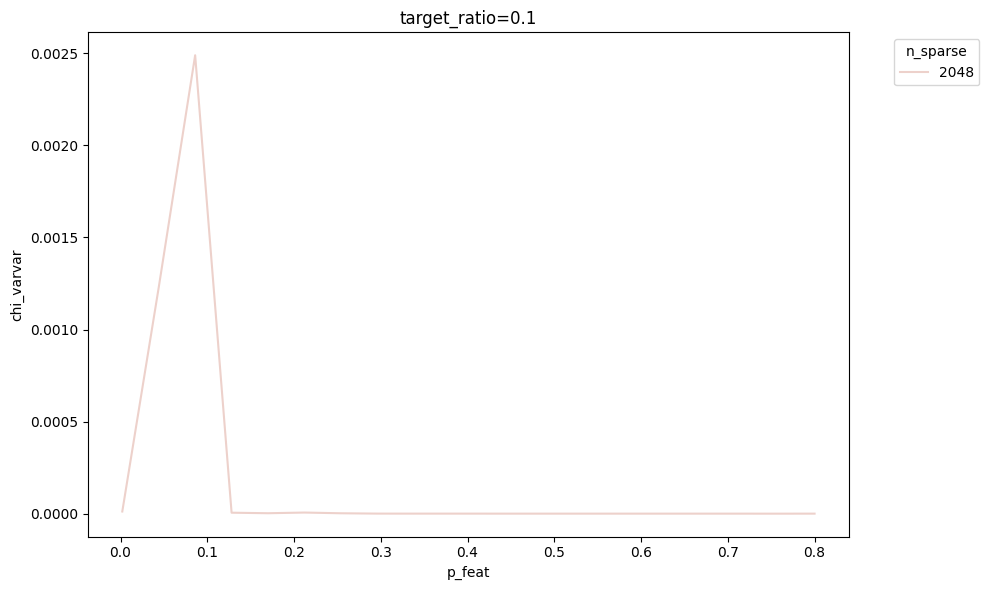

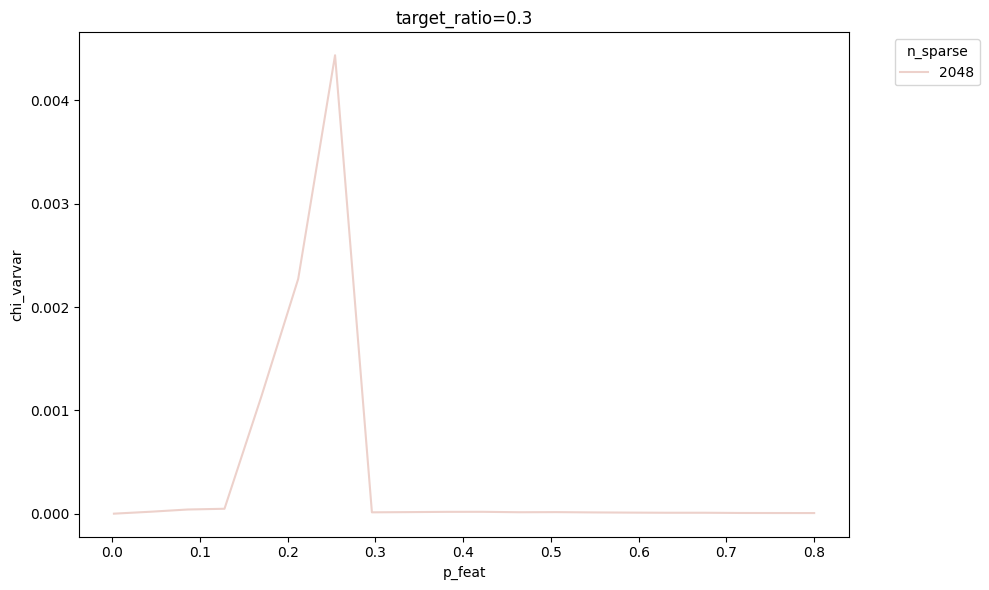

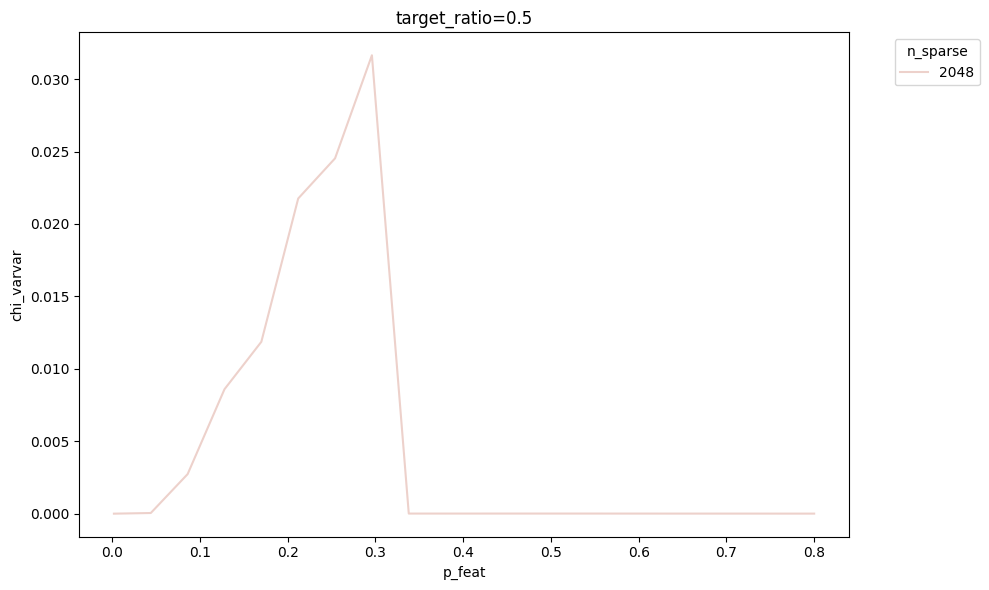

In [166]:
ratios_to_plot = [0.001, 0.1, 0.3, 0.5]
for target_ratio in ratios_to_plot:
    target_df = ma.get_closest_models_df(df, ['n_sparse', 'p_feat'], ratio=target_ratio)
    lrp.plot_columns(target_df, 'p_feat', 'chi_varvar', 'n_sparse', title=f'{target_ratio=}')




100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


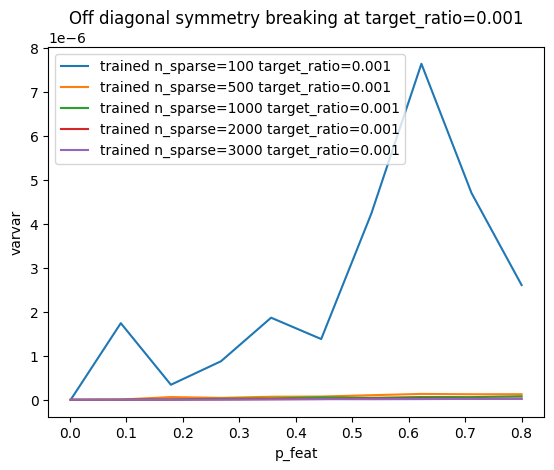

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


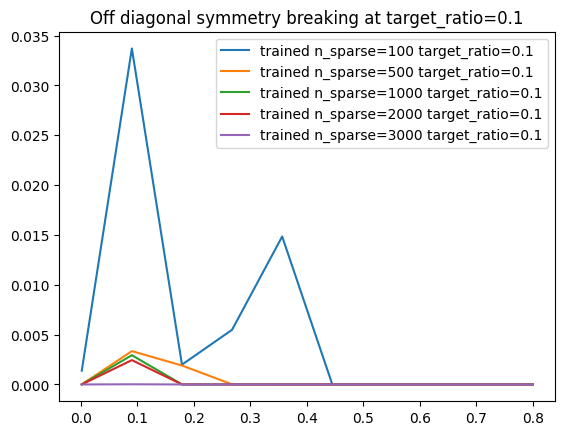

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


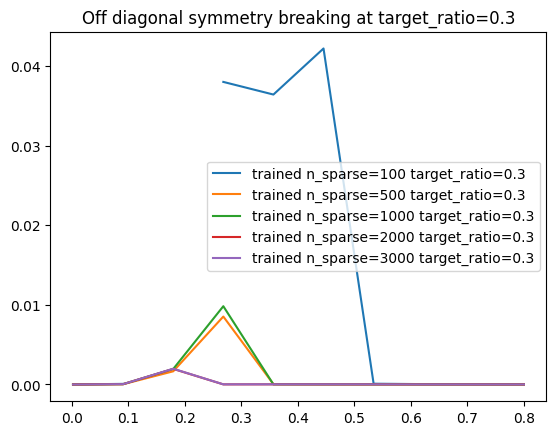

100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


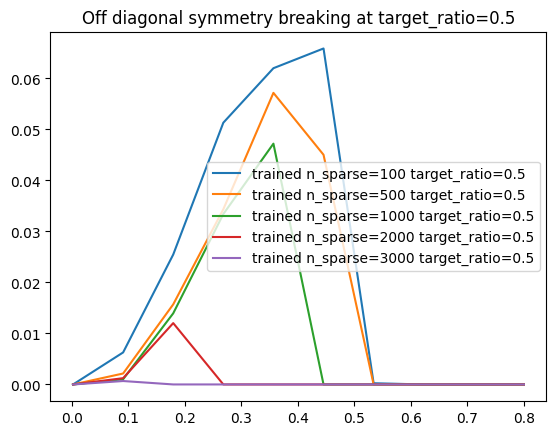

In [20]:
def const_ratio_data(models, func, target_ratio=0.1):

    ratios = sorted(list({model.ratio() for model in models}))
    p_feats = sorted(list({model.p_feat for model in models}))
    closest_ratio = sorted(ratios, key=lambda x: np.abs(x-target_ratio))[0]
    #print(f'{closest_ratio=}')

    def ratio_filter(models, ratio): 
        return sorted([model for model in models if model.ratio() == ratio], key=lambda model: model.p_feat)

    filtered_models = ratio_filter(models, closest_ratio)
    
    return p_feats, [func(model) for model in filtered_models]

plt.xlabel("p_feat")
plt.ylabel("varvar")

ratios_to_plot = [0.001, 0.1, 0.3, 0.5]

for target_ratio in ratios_to_plot: 
    for n_sparse in tqdm(LRP_n_sparses_2):
        nl_models = LRP_nonlin_trained_models(n_sparse)
        x,y = const_ratio_data(nl_models, varvar2, target_ratio)
        plt.plot(x,y, label=f'trained {n_sparse=} {target_ratio=}')
        plt.title(f'Off diagonal symmetry breaking at {target_ratio=}')
    plt.legend()
    plt.show()





### 

# Trained vs Hadamard

In [17]:
test_n_s = 128
test_n_d = 70
test_p_f = 0.1


In [18]:
hadamard_models = LRP_hadamard_models(128)

AttributeError: module 'utils.model_scan' has no attribute 'train_multiple_hadamard_models'

In [ ]:
hadamard_models2 = LRP_hadamard_models(128)

Ratio: N/A, p_feat: N/A, Loss: N/A:   0%|          | 0/100 [00:00<?, ?it/s]/Users/dolev/Desktop/F. Cache/MechInterp/NonLinSAE/hadamard_model.py:120: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt_result = optimize.minimize_scalar(loss_to_minimize, bounds=(-1, 0), tol=.01)
Ratio: 0.80, p_feat: 0.8, Loss: 0.0200: 100%|██████████| 100/100 [23:13<00:00, 13.93s/it]               


### 2D plots

Ratio: N/A, p_feat: N/A, Loss: N/A:   0%|          | 0/100 [00:00<?, ?it/s]/Users/dolev/Desktop/F. Cache/MechInterp/NonLinSAE/hadamard_model.py:120: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt_result = optimize.minimize_scalar(loss_to_minimize, bounds=(-1, 0), tol=.01)
Ratio: 0.80, p_feat: 0.8, Loss: 0.0201: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]               


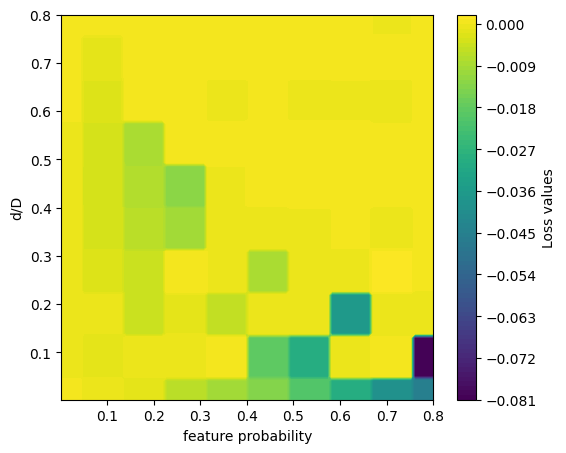

In [ ]:
import utils
reload(utils.plot.lrp)
#utils.plot.lrp.plot_loss_vs_r_and_p_diff(LRP_nonlin_trained_models(500),hadamard_models)
utils.plot.lrp.plot_loss_vs_r_and_p_diff(LRP_nonlin_trained_models(2000),hadamard_models)
#utils.plot.lrp.plot_loss_vs_r_and_p_diff(LRP_nonlin_trained_models(2000),hadamard_models2)




Ratio: N/A, p_feat: N/A, Loss: N/A:   0%|          | 0/100 [00:00<?, ?it/s]/Users/dolev/Desktop/F. Cache/MechInterp/NonLinSAE/hadamard_model.py:120: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt_result = optimize.minimize_scalar(loss_to_minimize, bounds=(-1, 0), tol=.01)
Ratio: 0.80, p_feat: 0.8, Loss: 0.0200: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]               


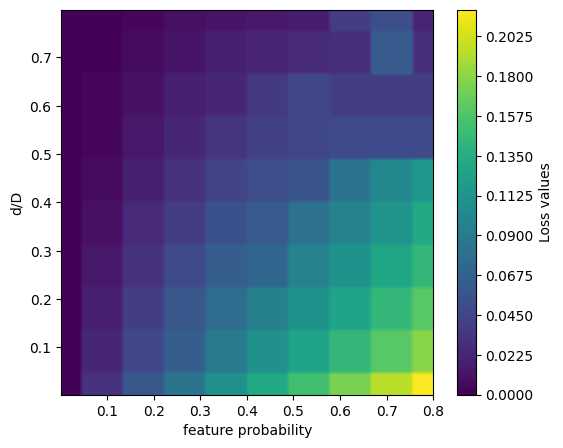

In [ ]:
import utils.plot.lrp
reload (utils.plot.lrp)
utils.plot.lrp.plot_loss_vs_r_and_p(hadamard_models, vmin=0, vmax=.3)

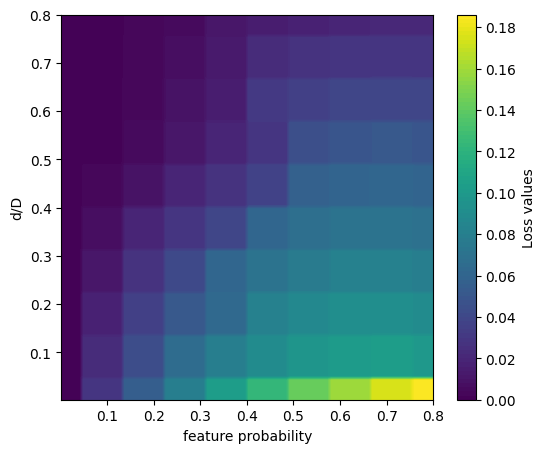

In [ ]:
utils.plot.lrp.plot_loss_vs_r_and_p(LRP_nonlin_trained_models(500), vmin=0, vmax=.3)

### Line cut plots fixed ratio

closest_ratio=0.53125
p_feats: [0.002001, 0.09066755555555556, 0.1793341111111111, 0.2680006666666666, 0.3566672222222222, 0.4453337777777778, 0.5340003333333333, 0.6226668888888889, 0.7113334444444445, 0.8]
losses: [1.357824839942623e-05, 0.004659561440348625, 0.013619628734886646, 0.023328710347414017, 0.03300022706389427, 0.04075899347662926, 0.045437563210725784, 0.04863410443067551, 0.05023181065917015, 0.04884413257241249]
closest_ratio=0.534
closest_ratio=0.53


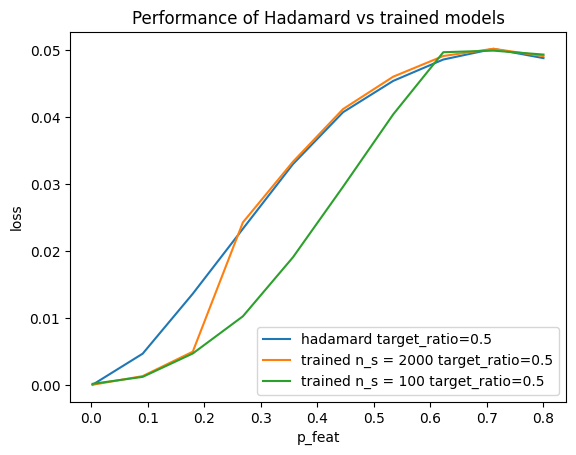

In [ ]:
def const_ratio_data(models, target_ratio=0.1):

    ratios = sorted(list({model.ratio() for model in models}))
    p_feats = sorted(list({model.p_feat for model in models}))
    closest_ratio = sorted(ratios, key=lambda x: np.abs(x-target_ratio))[0]
    #print(f'{closest_ratio=}')

    def ratio_filter(models, ratio): 
        return sorted([model for model in models if model.ratio() == ratio], key=lambda model: model.p_feat)

    filtered_models = ratio_filter(models, closest_ratio)
    #print(f'{[model.ratio() for model in filtered_models]=}')
    print(f'{closest_ratio=}')

    # print(f'{len(p_feats)=}')
    # print(f'{len(filtered_models)=}')
    
    return p_feats, [model.final_loss() for model in filtered_models]

plt.xlabel("p_feat")
plt.ylabel("loss")
plt.title("Performance of Hadamard vs trained models")

ratios_to_plot = [0.5]


for target_ratio in ratios_to_plot: 
    x,y = const_ratio_data(hadamard_models, target_ratio)
    plt.plot(x,y, label=f'hadamard {target_ratio=}')
    print(f'p_feats: {x}')
    print(f'losses: {y}')    
        
    nl_models = LRP_nonlin_trained_models(2000)
    for target_ratio in ratios_to_plot: 
        x,y = const_ratio_data(nl_models, target_ratio)
        plt.plot(x,y, label=f'trained n_s = 2000 {target_ratio=}')

    nl_models = LRP_nonlin_trained_models(100)
    for target_ratio in ratios_to_plot: 
        x,y = const_ratio_data(nl_models, target_ratio)
        plt.plot(x,y, label=f'trained n_s = 100 {target_ratio=}')


plt.legend()
plt.show()


closest_p_feat=0.09066755555555556
ratios: [0.0078125, 0.0859375, 0.171875, 0.265625, 0.3515625, 0.4453125, 0.53125, 0.6171875, 0.7109375, 0.796875]
losses: [0.028607109561562538, 0.02432302199304104, 0.018450355157256126, 0.013650280423462391, 0.009128115139901638, 0.006854709703475237, 0.004659561440348625, 0.0032171227503567934, 0.0021843870636075735, 0.0012562748743221164]
closest_p_feat=0.09066755555555556
closest_p_feat=0.09066755555555556


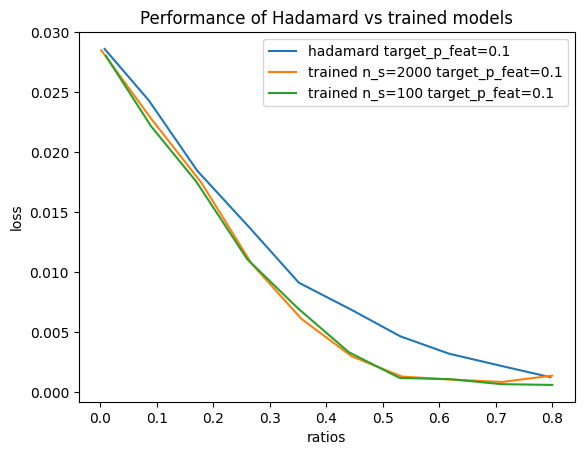

In [ ]:
def const_p_feat_data(models, target_ratio=0.1):

    ratios = sorted(list({model.ratio() for model in models}))
    p_feats = sorted(list({model.p_feat for model in models}))
    closest_p_feat = sorted(p_feats, key=lambda x: np.abs(x-target_ratio))[0]
    print(f'{closest_p_feat=}')

    def p_feat_filter(models, p_feat): 
        return sorted([model for model in models if model.p_feat == p_feat], key=lambda model: model.ratio())

    filtered_models = p_feat_filter(models, closest_p_feat)

    # print(f'{len(p_feats)=}')
    # print(f'{len(filtered_models)=}')
    
    return ratios, [model.final_loss() for model in filtered_models]

plt.xlabel("ratios")
plt.ylabel("loss")
plt.title("Performance of Hadamard vs trained models")

p_feats_to_plot = [0.1]

for target_p_feat in p_feats_to_plot: 
    x,y = const_p_feat_data(hadamard_models, target_p_feat)
    print(f'ratios: {x}')
    print(f'losses: {y}')
    plt.plot(x,y, label=f'hadamard {target_p_feat=}')
    
nl_models = LRP_nonlin_trained_models(2000)
for target_p_feat in p_feats_to_plot: 
    x,y = const_p_feat_data(nl_models, target_p_feat)
    plt.plot(x,y, label=f'trained n_s=2000 {target_p_feat=}')
    
nl_models = LRP_nonlin_trained_models(100)
for target_p_feat in p_feats_to_plot: 
    x,y = const_p_feat_data(nl_models, target_p_feat)
    plt.plot(x,y, label=f'trained n_s=100 {target_p_feat=}')
    
# nl_models = LRP_nonlin_trained_models(500)
# for target_p_feat in p_feats_to_plot: 
#     x,y = const_p_feat_data(nl_models, target_p_feat)
#     plt.plot(x,y, label=f'trained n_s=500 {target_p_feat=}')

plt.legend()
plt.show()


# Unsorted

## Optimal symmetric LRP

The optimal one saturates the bound aditya derived $\sum_{i}\frac{\sigma_{\chi_i}^2}{n_s} >\frac{n_s}{n_d}-1$ which is true for any W with all ones on the diagonal

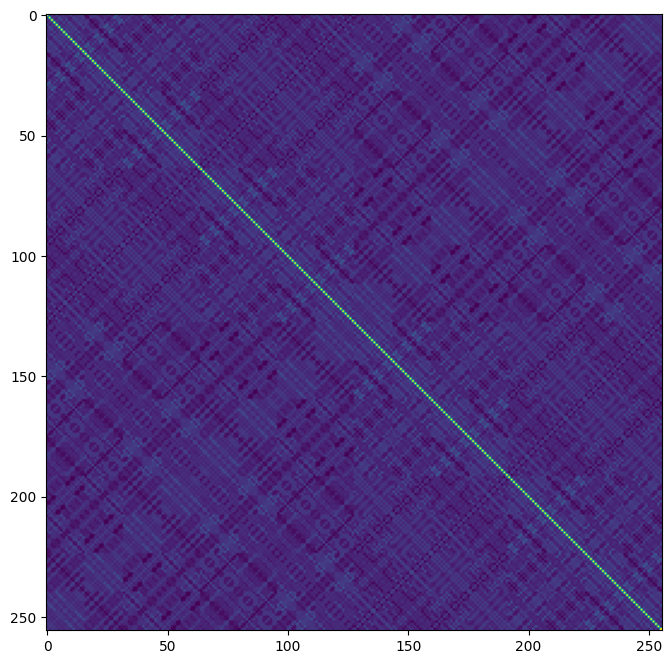

In [68]:
import numpy as np
from scipy.linalg import hadamard

def hadamard_transform(v):
    """Apply a discrete Hadamard transform to vector v."""
    h_matrix = hadamard(len(v))  # Generate Hadamard matrix of appropriate size
    return np.dot(h_matrix, v)

def unit_vector(size, index):
    """Return a unit vector of size 'size' with 1 at 'index' position."""
    v = np.zeros(size)
    v[index] = 1
    return v

def proj(ns, nd):
    """Projection function equivalent to the Mathematica version."""
    indices = np.random.choice(range(ns), nd, replace=False)
    projection_sum = np.zeros((ns, ns))
    
    for i in indices:
        u = unit_vector(ns, i)
        hadamard_u = hadamard_transform(u)
        projection_sum += np.outer(hadamard_u, hadamard_u)
    
    return projection_sum * ns / nd

# Example usage
ns = 256  # Dimension of the space (should be a power of 2 for Hadamard)
nd = 133  # Dimension for the projection
plt.figure(figsize=(10, 8))
projection_matrix = proj(ns, nd)
plt.imshow(projection_matrix)


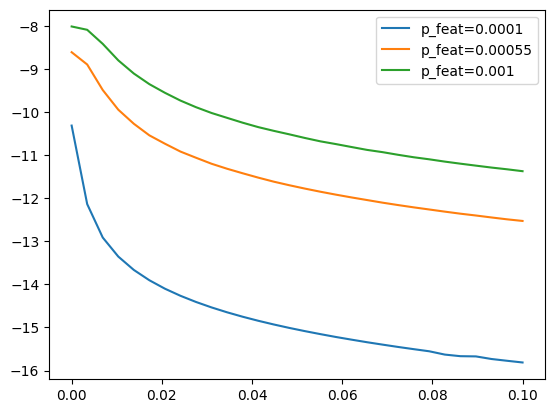

In [57]:
from scipy.integrate import quad as integrate
from utils.synthetic_model import optimal_A, mean
def LRP(r, p):
    D = 10000000
    d = max(int(r*D),1)
    opt_k = 0
    opt_loss = np.inf
    opt_A = 0.0
    k = d // 2 + 1
    
    A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
    l = p / 3 - A * p * num

    # if l < opt_loss:
    #     opt_k = k 
    #     opt_loss = l
    #     opt_A = A

    while opt_loss > l:
        opt_k = k 
        opt_loss = l
        opt_A = A

        k -= 1
        A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
        l = p / 3 - A * p * num
        
    
    return opt_loss

p = 0.0001
r_min = 0.00001
r_max = 0.1
ratios = np.linspace(r_min, r_max, 30)
p_feats = np.linspace(0.0001,0.001, 3)
for p_feat in p_feats:
    losses = np.array([np.log(LRP(r,p_feat)) for r in ratios])
    plt.plot(ratios,losses, label=f'{p_feat=}')
plt.legend()
plt.show()

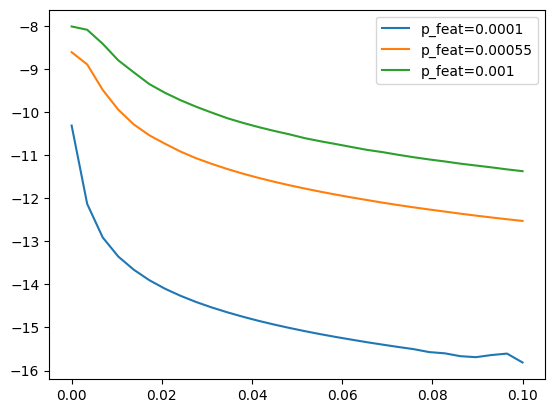

In [55]:
from scipy.integrate import quad as integrate
from utils.synthetic_model import optimal_A, mean
def LRP(r, p):
    D = 100000
    d = max(int(r*D),1)
    opt_k = 0
    opt_loss = np.inf
    opt_A = 0.0
    k = d // 2 + 1
    
    A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
    l = p / 3 - A * p * num

    # if l < opt_loss:
    #     opt_k = k 
    #     opt_loss = l
    #     opt_A = A

    while opt_loss > l:
        opt_k = k 
        opt_loss = l
        opt_A = A

        k -= 1
        A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
        l = p / 3 - A * p * num
        
    
    return opt_loss

p = 0.0001
r_min = 0.00001
r_max = 0.1
ratios = np.linspace(r_min, r_max, 30)
p_feats = np.linspace(0.0001,0.001, 3)
for p_feat in p_feats:
    losses = np.array([np.log(LRP(r,p_feat)) for r in ratios])
    plt.plot(ratios,losses, label=f'{p_feat=}')
plt.legend()
plt.show()

100%|██████████| 39/39 [00:06<00:00,  6.41it/s]


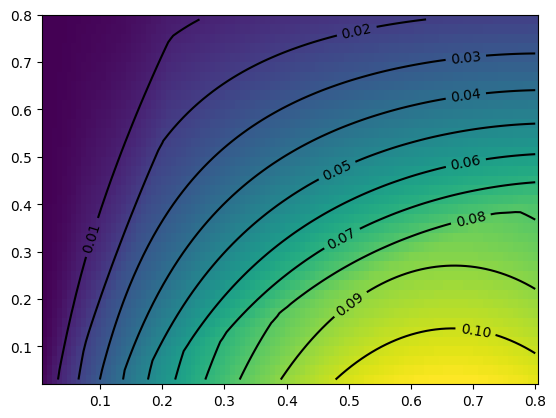

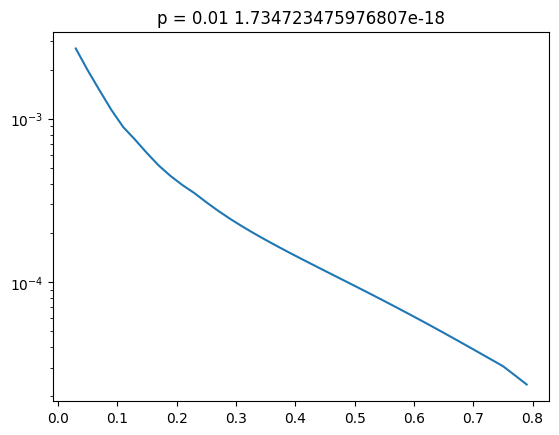

In [13]:
def gs_analytic_compare():
    from scipy.integrate import quad as integrate
    from utils.synthetic_model import optimal_A, mean
    
    def variance(k, d, D, p):
        return (D/d - 1) * (p/3 - p**2/4)

    def optimal_params(d, D, p):
        opt_k = 0
        opt_loss = np.inf
        opt_A = 0.0
        k = d // 2 + 1
        
        A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
        l = p / 3 - A * p * num

        # if l < opt_loss:
        #     opt_k = k 
        #     opt_loss = l
        #     opt_A = A

        while opt_loss > l:
            opt_k = k 
            opt_loss = l
            opt_A = A

            k -= 1
            A, num = optimal_A(mean(k, d, D, p), variance(k, d, D, p)**.5, p) 
            l = p / 3 - A * p * num
            
        
        return opt_k, opt_A, opt_loss


    n_sparse = 5000
    # optimal_A(mean(198, 400, 5000, .03), variance(198, 400, 5000, .03)**.5, .03)
    X, Y = np.meshgrid(np.arange(int(.03 * n_sparse), int(0.8*n_sparse), 100), np.linspace(.01, .8, 100), indexing='ij')
    C = np.zeros_like(Y)
    for i in tqdm(range(X.shape[0])):
        for j in range(Y.shape[1]):
            C[i, j] = optimal_params(X[i,j], n_sparse, Y[i, j])[-1]
    
    plt.pcolormesh(Y, X / float(n_sparse), C)
    CS = plt.contour(Y, X/float(n_sparse), C, colors='black', levels=10)
    # plt.colorbar()
    plt.clabel(CS, inline=True, fontsize=10)

    plt.show()

    plt.semilogy(X[:, 0] / float(n_sparse), C[:, 0])
    plt.title(f'p = {Y[0, 0]} {Y[:, 0].std()}')
    plt.show()

gs_analytic_compare()


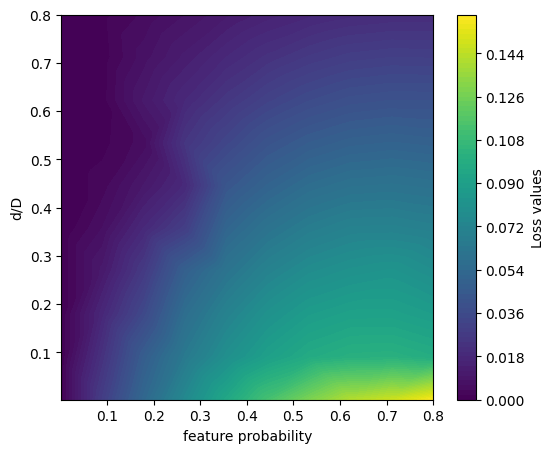

In [6]:
plot_loss_vs_r_and_p(LRP_nonlin_trained_models(2000))

## Sum of epsilon squares

In [10]:
import importlib
importlib.reload(ms)

<module 'utils.model_scan' from '/Users/dolev/Desktop/MechInterp/NonLinSAE/utils/model_scan.py'>

In [81]:
import copy

def get_eps2_from_model(model):
    W = model.W_matrix().detach().clone()
    eps = W * (1 - t.eye(W.size(0)))
    ans = (t.sum(eps**2).detach())/(model.cfg.n_sparse)
    return ans

def get_eps_max_from_model(model):
    W = model.W_matrix().detach().clone()
    eps = W * (1 - t.eye(W.size(0)))
    ans = (t.sum(eps**2).detach())/(model.cfg.n_sparse)
    return ans

In [79]:
experiment_name = f"eps_squared"
eps_n_sparses = np.ceil(np.linspace(100,1000,10)).astype(int)
try:
    eps_models = ms.load_trained_models(experiment_name)
except:
    eps_models = ms.train_multiple_models(eps_n_sparses, ratios=np.array([0.1]), p_feats=np.array([0.1]), non_linearity = True, experiment_name=experiment_name)

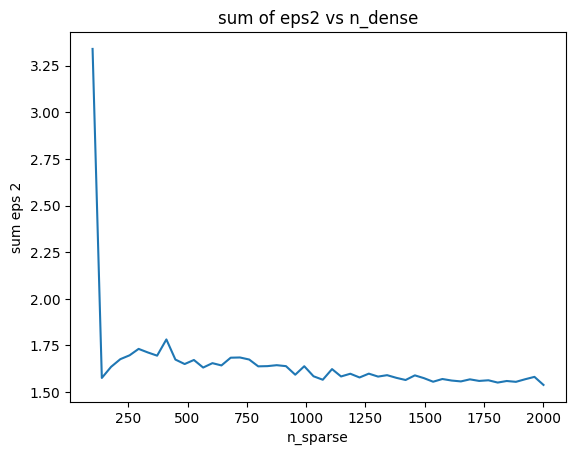

In [82]:
data = [(model.cfg.n_sparse, get_eps2_from_model(model).item()) for model in eps_models]
data.sort(key=lambda x: x[0])
x,y = zip(*data)
plt.xlabel("n_sparse")
plt.ylabel("sum eps 2")
plt.title(f'sum of eps2 vs n_dense')
plt.plot(x,y)

## Diagonal fluctuations

In [20]:
def diag_var(model):
    W = t.tensor(model.W_matrix())
    W = W.detach().clone()
    diags = W.diag()
    return diags.std()

### Trained linear

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/nn/7m22nts57j1427y3c7t0n9s40000gp/T/ipykernel_39844/2347664828.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = t.tensor(model.W_matrix())
100%|██████████| 100/100 [00:00<00:00, 24949.76it/s]


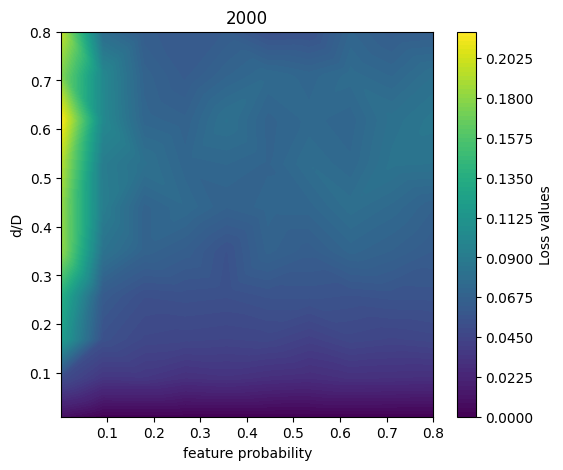

0.065698124


In [43]:
plot_model_func_vs_r_and_p(LRP_lin_trained_models(100), diag_var, title=f'{n_sparse}')
x=np.array([diag_var(model) for model in LRP_lin_trained_models(100)]).mean()
print(x)


### Trained non-linear

In [22]:
def diag_var_filter(model):
    W = t.tensor(model.W_matrix())
    W = W.detach().clone()
    diags = W.diag()
    ans = diags.std()
    return ans if ans <0.1 else 0

In [267]:
t.nan

nan

In [266]:
reload(ma)
col_name = 'filtered_diag_var'
df[col_name] = df['model_id'].apply(lambda x: ma.diag_var_filter(model_dict[x], threshold=0.1))

for n_sparse in LRP_n_sparses:
    lrp.plot_column_vs_r_and_p(df[df.n_sparse == n_sparse], col_name, title=f'{n_sparse=}', colorbar_label=label_map[col_name])


RuntimeError: latex was not able to process the following string:
b'log\\\\min(\\\\mathrm{var}_i \\\\mathrm{diag}(W),T)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpj28otlcx a898817960a1ca73d2d3fb366f3ddff4.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./a898817960a1ca73d2d3fb366f3ddff4.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file a898817960a1ca73d2d3fb366f3ddff4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.29 {\sffamily log\min
                       (\mathrm{var}_i \mathrm{diag}(W),T)}%
No pages of output.
Transcript written on tmpj28otlcx/a898817960a1ca73d2d3fb366f3ddff4.log.




<Figure size 600x500 with 2 Axes>

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/nn/7m22nts57j1427y3c7t0n9s40000gp/T/ipykernel_94528/987079403.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = t.tensor(model.W_matrix())
100%|██████████| 100/100 [00:00<00:00, 26056.43it/s]


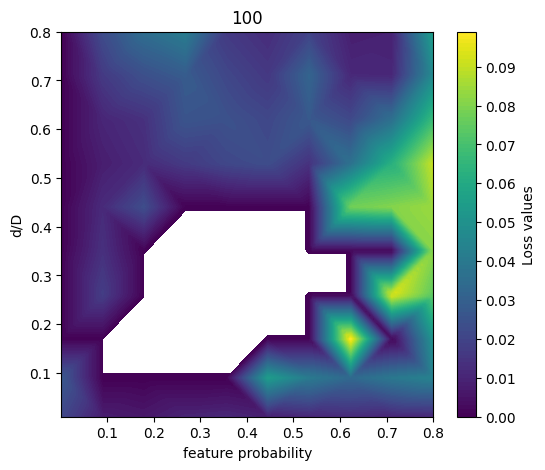

100%|██████████| 100/100 [00:00<00:00, 2386.59it/s]


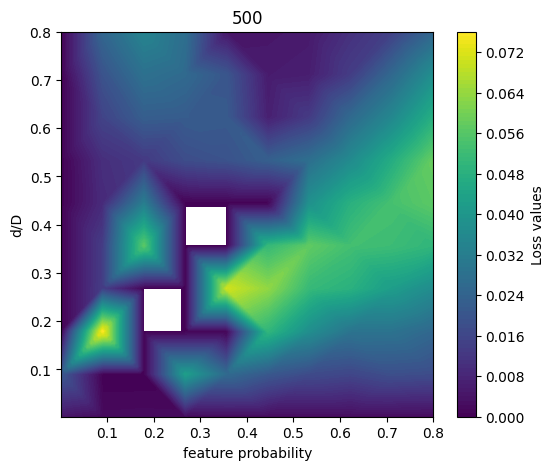

100%|██████████| 100/100 [00:00<00:00, 176.58it/s]


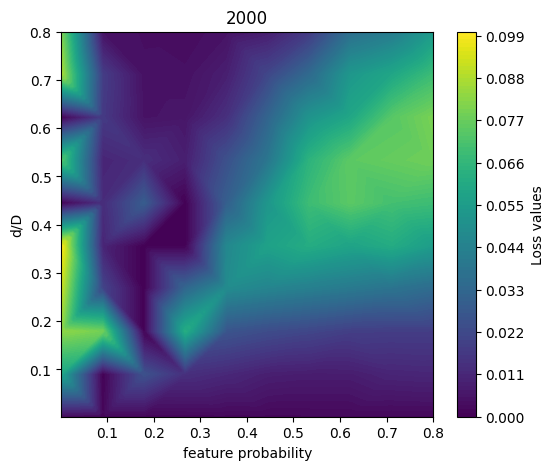

In [25]:
for n_sparse in LRP_n_sparses:
    plot_model_func_vs_r_and_p(LRP_nonlin_trained_models(n_sparse), diag_var_filter, title=f'{n_sparse}')


In [37]:
for n_sparse in LRP_n_sparses:
    x=np.array([diag_var(model) for model in LRP_nonlin_trained_models(n_sparse)]).mean()
    print(f'mean of diagonal fluctuations n_sparse={n_sparse} is {x}')

/var/folders/nn/7m22nts57j1427y3c7t0n9s40000gp/T/ipykernel_39844/2347664828.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = t.tensor(model.W_matrix())


mean of n_sparse=100 is 0.152475968003273
mean of n_sparse=200 is 0.132711261510849
mean of n_sparse=500 is 0.09029050916433334
mean of n_sparse=2000 is 0.056797247380018234


### Synthetic

100%|██████████| 100/100 [00:00<00:00, 200.15it/s]


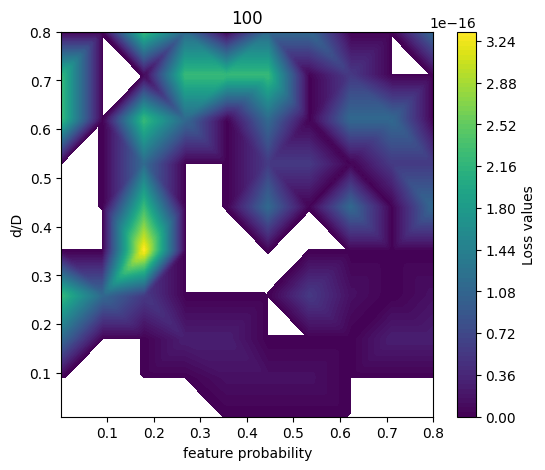

100%|██████████| 100/100 [00:01<00:00, 83.70it/s]


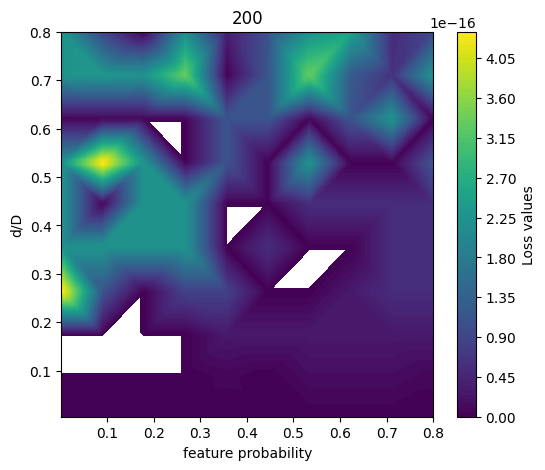

100%|██████████| 100/100 [00:03<00:00, 31.88it/s]


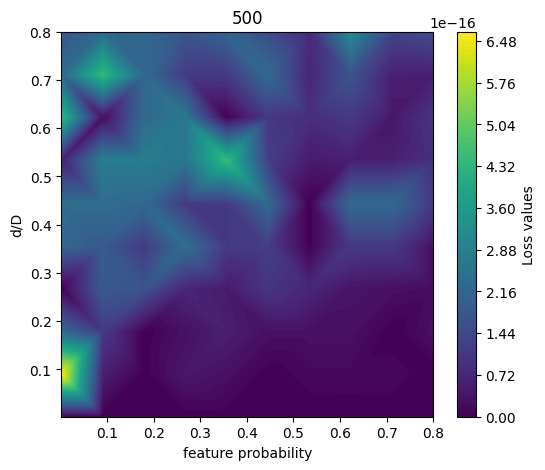

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


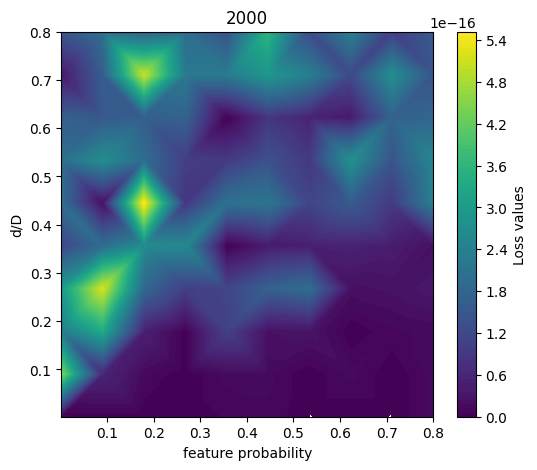

In [32]:
for n_sparse in LRP_n_sparses:
    plot_model_func_vs_r_and_p(LRP_synthetic_models(n_sparse), diag_var, title=f'{n_sparse}')


In [39]:
for n_sparse in LRP_n_sparses:
    x=np.array([diag_var(model) for model in LRP_synthetic_models(n_sparse)]).mean()
    print(f'mean of diagonal fluctuations n_sparse={n_sparse} is {x}')

Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 273.38it/s]               


mean of n_sparse=100 is 4.477212194017964e-17


Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 185.68it/s]               


mean of n_sparse=200 is 8.043236565159407e-17


Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 211.35it/s]               


mean of n_sparse=500 is 1.2019161053323811e-16


Ratio: 0.00, p_feat: 0.5340003333333333, Loss: 0.1512:   0%|          | 0/100 [00:00<?, ?it/s] /Users/dolev/Desktop/MechInterp/NonLinSAE/utils/synthetic_model.py:41: RuntimeWarning: invalid value encountered in scalar divide
  return p*numerator / (p * denom_1 + (1-p) * denom_2), numerator / np.sqrt(2 * np.pi) / sigma
Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 200.32it/s]               


mean of n_sparse=2000 is 1.274967915904919e-16


Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 244.08it/s]               


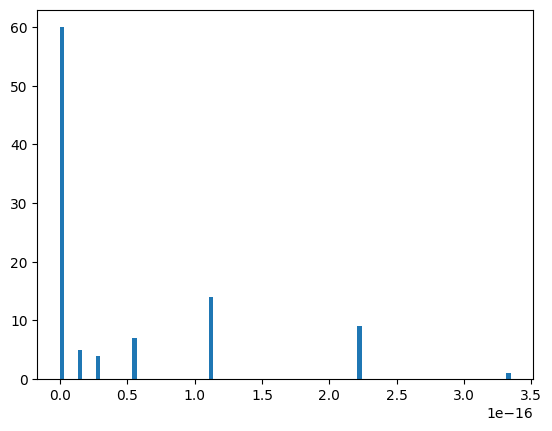

Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 233.26it/s]               


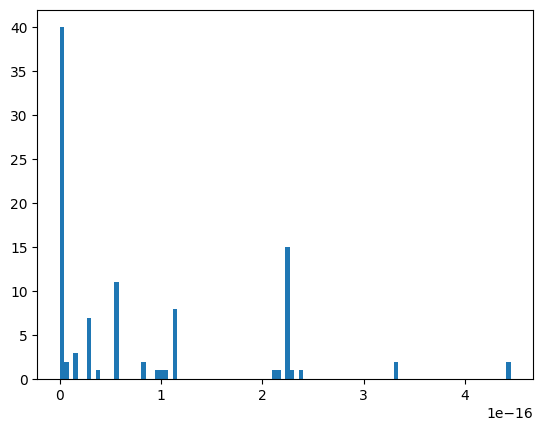

Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 222.18it/s]               


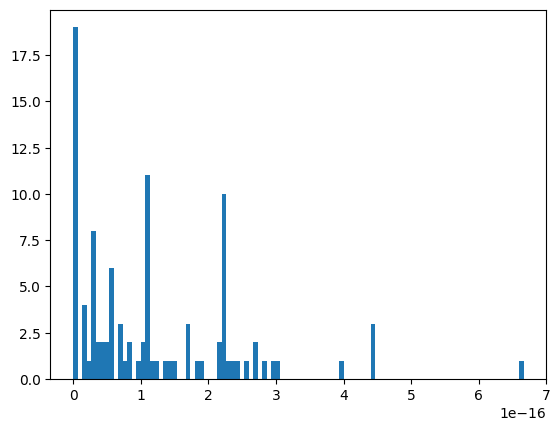

Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 218.61it/s]               


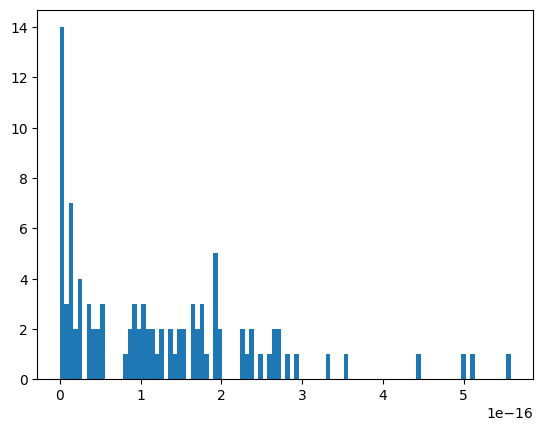

In [33]:
for n_sparse in LRP_n_sparses:
    plt.hist([diag_var(model) for model in LRP_synthetic_models(n_sparse)], bins=100)
    plt.show()

### Comparings diagonal hists for lin vs non lin

In [32]:
x = [2,1]
x.sort()
x

[1, 2]

In [103]:
n_s=100
print(f'n_sparse is {n_s}')
target_p_feat = 0.1
target_p_feat = 0.3
lin_model = get_closest_model(LRP_lin_trained_models(n_s), target_p_feat, target_p_feat)
non_model = get_closest_model(LRP_nonlin_trained_models(n_s), target_p_feat, target_p_feat)

n_sparse is 100


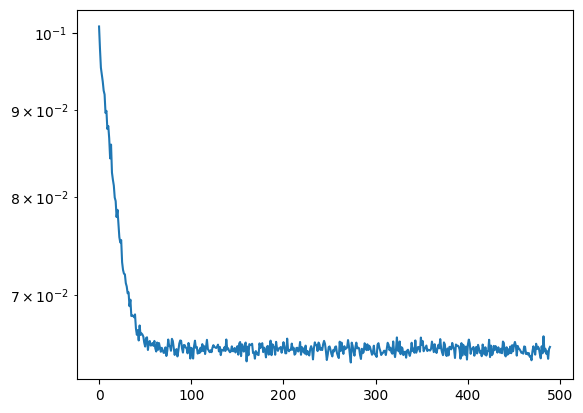

In [104]:


plt.semilogy(lin_model.losses)

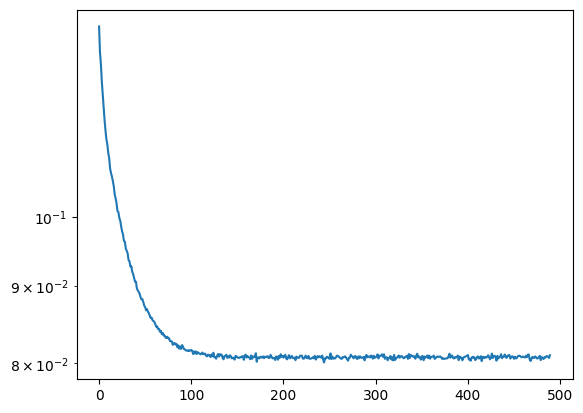

In [105]:
plt.semilogy(nlin_model.losses)

n_sparse is 100
t.mean(get_diags(model))=tensor(0.7129)
t.var(get_diags(model))=tensor(0.1828)


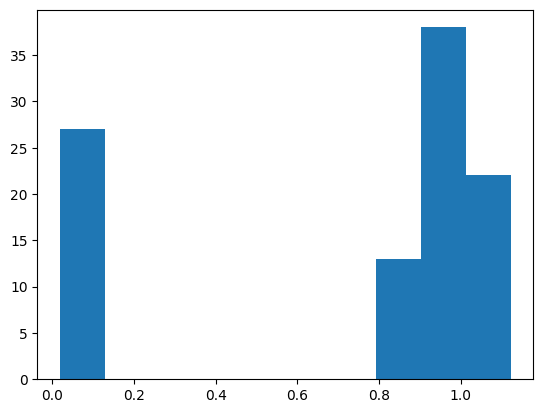

n_sparse is 500
t.mean(get_diags(model))=tensor(0.7980)
t.var(get_diags(model))=tensor(0.1451)


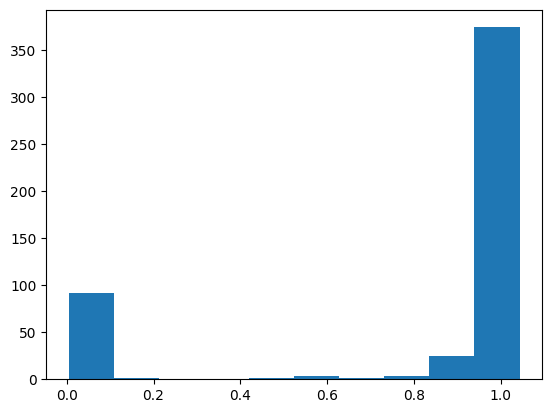

n_sparse is 2000
t.mean(get_diags(model))=tensor(0.7920)
t.var(get_diags(model))=tensor(0.1903)


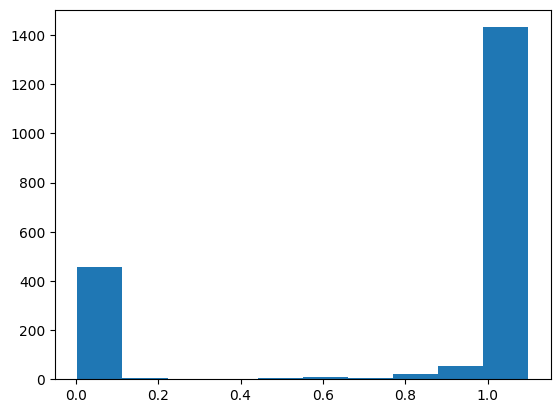

In [29]:
for n_s in LRP_n_sparses:
    print(f'n_sparse is {n_s}')
    target_p_feat = 0.3
    target_p_feat = 0.2
    lin_model = get_closest_model(LRP_lin_trained_models(n_s), target_p_feat, target_p_feat)
    non_model = get_closest_model(LRP_nonlin_trained_models(n_s), target_p_feat, target_p_feat)

    x = get_closest_model(LRP_lin_trained_models(n_s), 0.1,0.5)
    def get_diags(model):
        W = model.W_matrix()
        return t.diag(W)

    for model in [non_model]:
        print(f'{t.mean(get_diags(model))=}')
        print(f'{t.var(get_diags(model))=}')
        plt.hist(get_diags(model))
        plt.show()

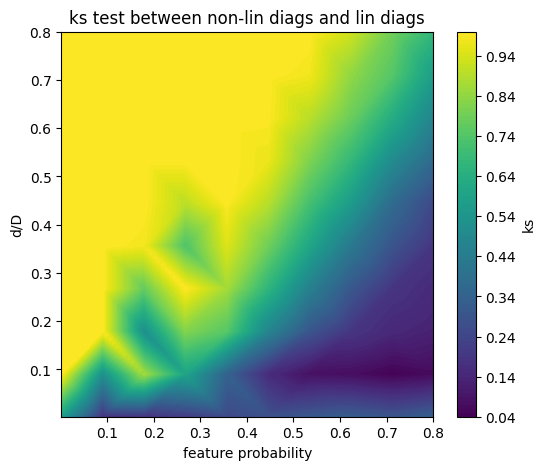

In [77]:
data = []

n_s = 2000
nlin_models = LRP_nonlin_trained_models(n_s)
for lin_model in LRP_lin_trained_models(n_s):
    nlin_model = get_closest_model(nlin_models, lin_model.ratio(), lin_model.p_feat)
    lin_diags = get_diags(lin_model)
    nlin_diags = get_diags(nlin_model)
    ks_statistic, p_value = sp.stats.ks_2samp(nlin_diags, lin_diags)
    data.append((lin_model.ratio(), lin_model.p_feat, ks_statistic))
    

# Separate the tuples into three lists a, b, and c
ratios, p_feats, losses = zip(*data)

# Convert lists to numpy arrays
ratios = np.array(ratios)
p_feats = np.array(p_feats)
losses = np.array(losses)
#losses = np.array([min(loss, .05) for loss in losses])

# Define a finer grid for interpolation
a_fine = np.linspace(min(ratios), max(ratios), 100)
b_fine = np.linspace(min(p_feats), max(p_feats), 100)
A_fine, B_fine = np.meshgrid(a_fine, b_fine)

# Interpolate the c values over the finer grid using 'linear' method
C_fine = sp.integrate.griddata((ratios, p_feats), losses, (A_fine, B_fine), method='linear')

# Plotting the smooth heatmap
plt.figure(figsize=(6, 5))
plt.contourf(B_fine, A_fine, C_fine, 100, cmap='viridis')
plt.colorbar(label='ks')
plt.ylabel('d/D')
plt.xlabel('feature probability')
plt.title("ks test between non-lin diags and lin diags")
plt.show()


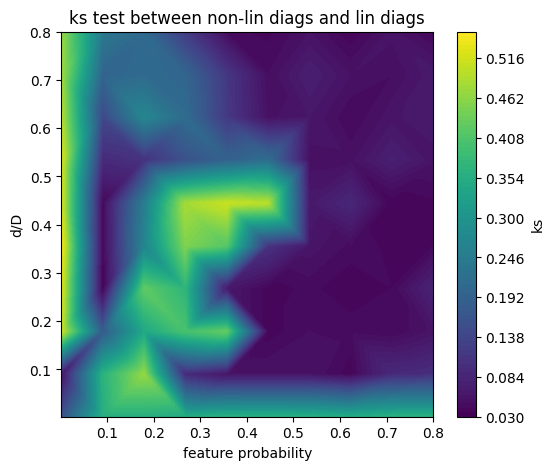

In [85]:
def normalize(data):
    data = data-data.mean()
    data = data/data.std()
    return data

data = []

n_s = 500
nlin_models = LRP_nonlin_trained_models(n_s)
for lin_model in LRP_lin_trained_models(n_s):
    nlin_model = get_closest_model(nlin_models, lin_model.ratio(), lin_model.p_feat)
    lin_diags = normalize(get_diags(lin_model))
    nlin_diags = normalize(get_diags(nlin_model))
    ks_statistic, p_value = sp.stats.ks_2samp(nlin_diags, lin_diags)
    data.append((lin_model.ratio(), lin_model.p_feat, ks_statistic))
    

# Separate the tuples into three lists a, b, and c
ratios, p_feats, losses = zip(*data)

# Convert lists to numpy arrays
ratios = np.array(ratios)
p_feats = np.array(p_feats)
losses = np.array(losses)
#losses = np.array([min(loss, .05) for loss in losses])

# Define a finer grid for interpolation
a_fine = np.linspace(min(ratios), max(ratios), 100)
b_fine = np.linspace(min(p_feats), max(p_feats), 100)
A_fine, B_fine = np.meshgrid(a_fine, b_fine)

# Interpolate the c values over the finer grid using 'linear' method
C_fine = sp.integrate.griddata((ratios, p_feats), losses, (A_fine, B_fine), method='linear')

# Plotting the smooth heatmap
plt.figure(figsize=(6, 5))
plt.contourf(B_fine, A_fine, C_fine, 100, cmap='viridis')
plt.colorbar(label='ks')
plt.ylabel('d/D')
plt.xlabel('feature probability')
plt.title("ks test between non-lin diags and lin diags")
plt.show()


## Does W_nonlin become a projector?

## Simple synthetic model

We now present a choice for $W_{\text{in}}$ and $W_{\text{out}}$ that captures the salient features we describe above. For each feature $i$, we choose a uniformly random set $G_i\subseteq\{1,...,d\}$ of size $k$. We then set 
$$
(W_{\text{in}})_{ji} = \begin{cases} \frac{1}{k} &\text{if } j \in G_i \\
0 &\text{otherwise}
\end{cases}
$$
and 
$$
(W_{\text{out}})_{ij} = A \cdot \begin{cases}
1 &\text{if } j \in G_i \\
-1 &\text{otherwise} 
\end{cases}
$$

for some parameter $A$ which will control the norm of the diagonals. 
This choice of weights assures us that $(W_{\text{out}}W_{\text{in}})_{ii} = A$ and attempts to spread out correlations among the encoding and decoding vectors. $k$ allows us to control the mean overlap between different features which is mean-zero for $k=d/2$. By optimizing over $A$ and $k$, to capture the behavior of the norm and sign of the off diagonal components respectively, we hope to reproduce the behavior observed above.

In [ ]:
def gen_matrices(D, d, k):
    groups = [random.sample(range(d), k) for _ in range(D)]

    Win = np.zeros((d, D))
    Wout = -np.ones((D, d))

    for i, group in enumerate(groups):
        for g in group:
            Win[g, i] = 1/k
            Wout[i, g] = 1.0
    
    return Win, Wout

/tmp/ipykernel_209418/4238382855.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


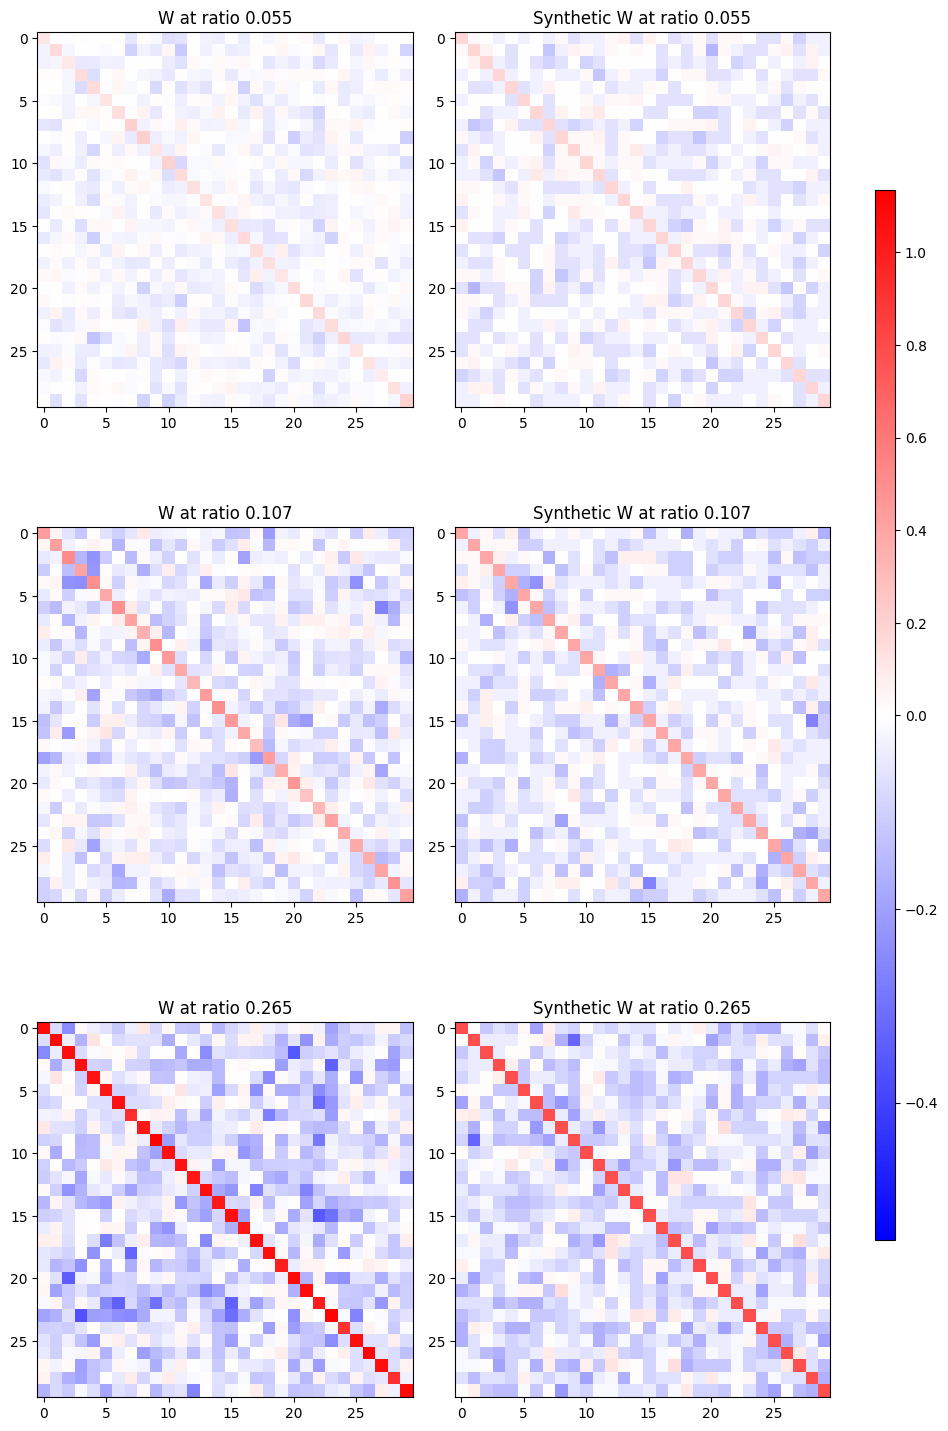

(tensor(-0.5424), tensor(1.1340))

In [ ]:
plot_Ws_and_Synthetic_Ws(plot_trained_Ws, plot_synthetic_Ws, plot_ratios)

## Loss v ratio & p_feat plots

Compare with paper "Statistical Mechanics of Compressed Sensing"

### Trained non-linear models

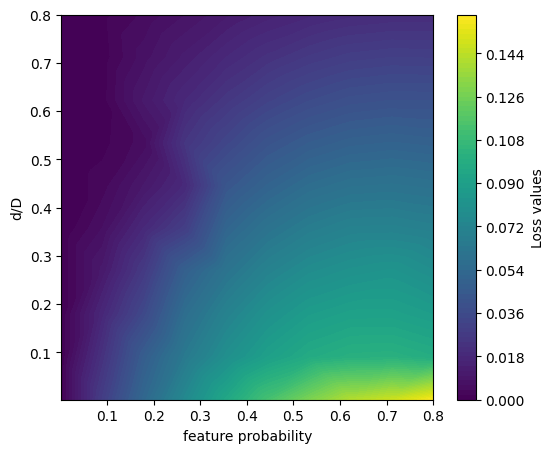

In [ ]:
plot_loss_vs_r_and_p(LRP_nonlin_trained_models(2000))

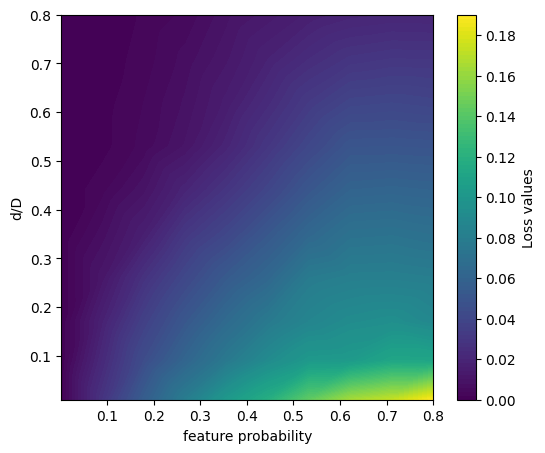

In [10]:
plot_loss_vs_r_and_p(LRP_nonlin_trained_models(100))

### Synthetic Models

Ratio: 0.00, p_feat: 0.5340003333333333, Loss: 0.1512:   0%|          | 0/100 [00:00<?, ?it/s] /Users/dolev/Desktop/MechInterp/NonLinSAE/utils/synthetic_model.py:41: RuntimeWarning: invalid value encountered in scalar divide
  return p*numerator / (p * denom_1 + (1-p) * denom_2), numerator / np.sqrt(2 * np.pi) / sigma
Ratio: 0.80, p_feat: 0.8, Loss: 0.0204: 100%|██████████| 100/100 [00:00<00:00, 335.06it/s]               


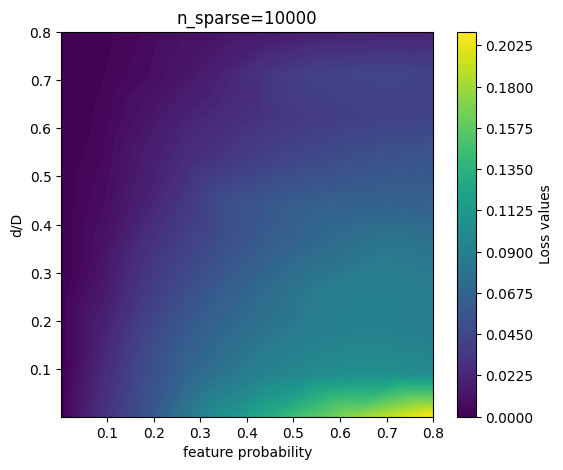

In [ ]:
# LRP stands for "loss vs ratio, p_feat"
LRP_n_sparse = 10_000
experiment_name = f"LRP_{LRP_n_sparse}"
try:
    LRP_models_synthetic = ms.load_trained_models(experiment_name)
except:
    LRP_models_synthetic = None
    LRP_grid_width = 10
    LRP_ratios = np.linspace(0.002001, 0.8, LRP_grid_width)
    LRP_p_feats = np.linspace(0.002001, 0.8, LRP_grid_width)
    LRP_models_synthetic = ms.train_multiple_synthetic_models(LRP_n_sparse, LRP_ratios, LRP_p_feats)
    
plot_loss_vs_r_and_p(LRP_models_synthetic, title = f'n_sparse={LRP_n_sparse}')

In [116]:
evals.std()

1.3562881

n_sparse is 100


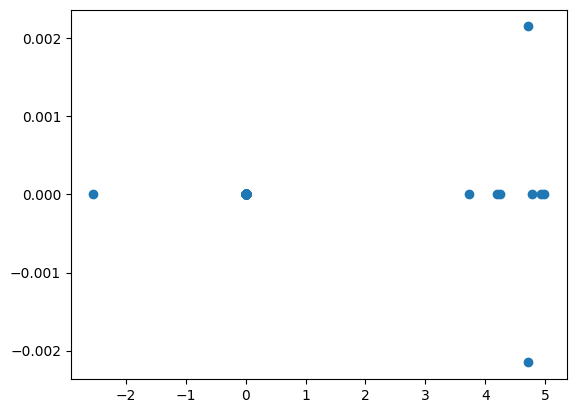

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [123]:
n_s=100
print(f'n_sparse is {n_s}')
target_p_feat = 0.1
target_p_feat = 0.1
non_model = get_closest_model(LRP_nonlin_trained_models(n_s), target_p_feat, target_p_feat)
W = non_model.W_matrix().detach().clone()
evals, _ = np.linalg.eig(W)
plt.scatter(np.real(evals), np.imag(evals))
plt.show()
plt.scatter()
plt.show()

n_sparse is 2000


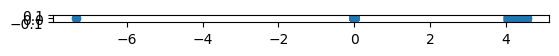

In [131]:
n_s=2000
print(f'n_sparse is {n_s}')
target_p_feat = 0.3
target_p_feat = 0.1
non_model = get_closest_model(LRP_nonlin_trained_models(n_s), target_p_feat, target_p_feat)
W = non_model.W_matrix().detach().clone()
evals, _ = np.linalg.eig(W)
plt.scatter(np.real(evals), np.imag(evals))
plt.gca().set_aspect("equal")
plt.ylim((-.1,.1))

plt.show()

## LRP varvar normalized

100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


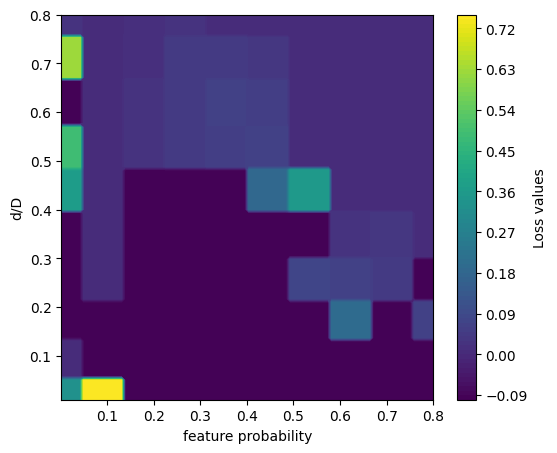

In [ ]:
def variances_norm(model):
    return [t.var(get_model_chi_data(model, num_points=100, row=row))/(model.W_matrix()[row,row])**2 for row in range(model.cfg.n_sparse)]

def varvar_norm(model):
    ans = np.var(variances_norm(model))
    return float(ans) if ans < 1 else -.1

plot_model_func_vs_r_and_p(LRP_nonlin_trained_models(100),varvar_norm)

100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


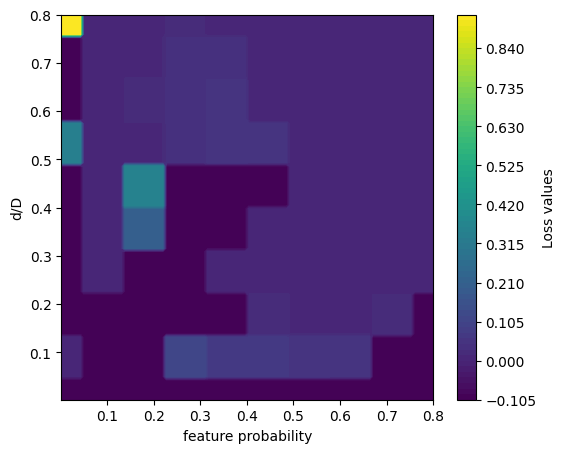

In [ ]:
def variances_norm(model):
    return [t.var(get_model_chi_data(model, num_points=100, row=row))/(model.W_matrix()[row,row])**2 for row in range(model.cfg.n_sparse)]

def varvar_norm(model):
    ans = np.var(variances_norm(model))
    return float(ans) if ans < 1 else -.1

plot_model_func_vs_r_and_p(LRP_nonlin_trained_models(500),varvar_norm)

In [27]:
test_model = model_dict[df['model_id'][0]]

In [110]:
import utils.linear_operators as wo
reload(wo)

<module 'utils.linear_operators' from '/Users/alexinf/Library/CloudStorage/Dropbox/github/InterpretabilityResearch/NonLinSAE/utils/linear_operators.py'>

In [118]:
reload(wo)
W = test_model.W_matrix()
a = wo.WOperator(test_model.initial_layer.weight.data.detach(), test_model.final_layer.weight.data.detach())
epsop = wo.EpsilonOperator(a)
randvec = t.randn(W.shape[0])
a @ randvec - W @randvec
epsop @ randvec - (W@randvec - t.diag(t.diag(W))@randvec)


tensor([[-1.1921e-07, -6.5565e-07,  8.3447e-07,  0.0000e+00,  4.7684e-07,
          9.5367e-07, -1.1921e-07,  2.3842e-07,  0.0000e+00, -1.1921e-07,
          8.9407e-08, -5.9605e-08,  1.1921e-07,  0.0000e+00, -2.3842e-07,
          2.3842e-07,  0.0000e+00, -2.3842e-07, -5.9605e-08,  3.5763e-07,
         -5.9605e-08, -8.3447e-07, -1.1921e-07, -2.3842e-07,  0.0000e+00,
         -1.1921e-07,  0.0000e+00,  5.9605e-08,  1.1921e-07, -4.7684e-07,
          7.1526e-07, -1.7881e-07, -5.9605e-07, -2.3842e-07,  0.0000e+00,
          2.3842e-07,  0.0000e+00,  9.5367e-07,  1.7881e-07,  0.0000e+00,
          2.3842e-07, -2.3842e-07,  0.0000e+00, -1.7881e-07,  0.0000e+00,
          2.3842e-07,  1.1921e-07, -2.3842e-07,  2.3842e-07,  2.0862e-07,
          7.1526e-07,  1.4901e-07, -2.3842e-07,  0.0000e+00, -4.7684e-07,
         -1.1921e-07,  0.0000e+00,  5.9605e-08,  0.0000e+00, -3.2783e-07,
          2.9802e-08,  4.7684e-07,  1.7881e-07,  0.0000e+00, -1.1921e-07,
          0.0000e+00,  1.1921e-07, -2.

In [107]:
a = t.zeros(5)
a.reshape(1,-1).shape

torch.Size([1, 5])